In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
#1Keras 2.2 is a high-level neural networks API, written in Python and capable of running on top of TensorFlow.
#1TensorFlow 1.11 (TF) is an open-source machine learning library for research and production


In [53]:
# initialisation du learning rate, nombre d'epochs et, batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [54]:
#1.DATA PREPROCESSING
data_path = "./Desktop/TP_OpenCV/datasets"
categories = ['with mask','without mask']
#categories = os.listdir(data_path)# select tous les types(fichier et dossier) du contenu "dataset": ici on a 2 dossier: with&withoutmask
#label = [i for i in range(len(categories))] #la longueur du dosier: 2(with_mask and without_mask) c à d: 0 et 1 index

#label_dict = dict(zip(categories,label)) #un dictionnaire contenant les deux variables


#print(label_dict)
#print(categories)
#print(label)

In [55]:
img_size = 224
data = []
labels = []

for category in categories:
    path = os.path.join(data_path, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

In [56]:
#One_Hot Encoding sur le label
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [57]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [58]:
#convertion en tableau numpy

In [59]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [60]:
#Train test split
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [61]:
#Data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [62]:
#MobileNetV2 est une architecture générale et peut être utilisé pour plusieurs cas d'utilisation. Selon le cas d'utilisation, 
#il peut utiliser différentes tailles de couche d'entrée et différents facteurs de largeur. Cela permet à des modèles de 
#largeurs différentes de réduire le nombre d'ajouts multiples et ainsi de réduire le coût d'inférence sur les appareils mobiles

#Transfer Learning
#Transfer learning in deep learning means to transfer knowledge from one domain to a similar one. In our example, 
#I have chosen the MobileNet V2 model because it’s faster to train and small in size. And most important, 
#MobileNet is pre-trained with ImageNet dataset.


In [63]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

In [64]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)#Full-connected
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)#output layer

In [65]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [66]:
# loop over all layers in the base model and freeze them so they will
# not be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [67]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


In [68]:
# train the head of the network
print("[INFO] training head...")
history = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
34/34 [==============================] - 78s 2s/step - loss: 0.3973 - accuracy: 0.8155 - val_loss: 0.1324 - val_accuracy: 0.9783
Epoch 2/20
34/34 [==============================] - 76s 2s/step - loss: 0.1059 - accuracy: 0.9775 - val_loss: 0.0647 - val_accuracy: 0.9928
Epoch 3/20
34/34 [==============================] - 71s 2s/step - loss: 0.0754 - accuracy: 0.9803 - val_loss: 0.0451 - val_accuracy: 0.9928
Epoch 4/20
34/34 [==============================] - 72s 2s/step - loss: 0.0540 - accuracy: 0.9850 - val_loss: 0.0367 - val_accuracy: 0.9928
Epoch 5/20
34/34 [==============================] - 73s 2s/step - loss: 0.0394 - accuracy: 0.9897 - val_loss: 0.0270 - val_accuracy: 0.9964
Epoch 6/20
34/34 [==============================] - 73s 2s/step - loss: 0.0328 - accuracy: 0.9934 - val_loss: 0.0241 - val_accuracy: 0.9964
Epoch 7/20
34/34 [==============================] - 74s 2s/step - loss: 0.0295 - accuracy: 0.9925 - val_loss: 0.0192 - val_accuracy: 0.9

In [69]:
model.save("last_Mask_Model.h5")

In [70]:
#chargement du model
from keras.models import load_model

In [71]:
model = load_model("last_Mask_Model.h5")

In [72]:
#predictions sur le model

In [73]:
prediction = model.predict(testX, batch_size=BS)

In [75]:
#affichage plus claire

In [76]:
predict = np.argmax(prediction, axis=1)

In [77]:
predict

array([0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0], dtype=int64)

In [78]:
#Encore mieux

In [79]:
print(classification_report(testY.argmax(axis=1), predict,
    target_names=lb.classes_))

              precision    recall  f1-score   support

   with mask       1.00      1.00      1.00       138
without mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [80]:
#VIsualization

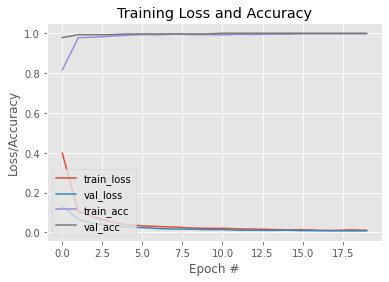

In [81]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")